In [2]:
# packages need for this scipt

# pip install mne
# pip install numpy
# pip install pandas
# pip install matplotlib
# pip install asrpy    #asr algorithm -> automatic noise rejection

# pip install EDFlib-Python  # export data to edf format
# pip install eeglabio # export data to .set format, which can be imported to eeglab 
# pip install openpyxl   #convert results into excel 
#pip install XlsxWriter  #write dataframe into excel

In [3]:
import os
import mne
import numpy as np
import pandas as pd
import asrpy
import matplotlib.pyplot as plt

# interactive plot 
#%matplotlib widget   

# static plot
%matplotlib inline  

In [4]:
# use asr algorithm to handle big noise pattern 

def  asr_noise_rejection(data, freq=250, blocksize= 200, cutoff=20, win_len=0.5, win_overlap=0.66 ):
    """
    ASR auto noise rejction
    Find big noise segment
    
    Artifact subspace reconstruction (ASR) is an automated, online,
    component-based artifact removal method for removing transient or
    large-amplitude artifacts in multi-channel EEG recordings [1]_.

    Parameters
    ----------   
    cutoff: float
        Standard deviation cutoff for rejection. X portions whose variance
        is larger than this threshold relative to the calibration data are
        considered missing data and will be removed. The most aggressive value
        that can be used without losing too much EEG is 2.5. Recommended to 
        use with more conservative values ranging from 20 - 30.
        Defaults to 20.
    blocksize : int
        Block size for calculating the robust data covariance and thresholds,
        in samples; allows to reduce the memory and time requirements of the
        robust estimators by this factor (down to Channels x Channels x Samples
        x 16 / Blocksize bytes) (default=100).
    win_len : float
        Window length (s) that is used to check the data for artifact content.
        This is ideally as long as the expected time scale of the artifacts but
        not shorter than half a cycle of the high-pass filter that was used
        (default=0.5).
    win_overlap : float
        Window overlap fraction. The fraction of two successive windows that
        overlaps. Higher overlap ensures that fewer artifact portions are going
        to be missed, but is slower (default=0.66).
    """

    asr = asrpy.ASR(
        sfreq=freq, 
        blocksize=blocksize, 
        cutoff=cutoff, 
        win_len=win_len, 
        win_overlap=win_overlap
    )

    asr.fit(data.load_data())
    data = asr.transform(data.load_data())
    
    return data

In [5]:
# Function to do slicing to crop bad durations out

def reject_bad_segs(raw):
    """ This function rejects all time spans annotated as 'bad' and concatenates the rest"""
    container_list = []
    for index in range(len(raw.annotations)-1): #index start with 0
        copy = raw.copy()
        duration = 0.2

        if index == 0:
            try: 
                cropped_raw = raw.copy().crop(tmin=0, tmax=raw.annotations[index]['onset']-duration/2)
            except ValueError:
                cropped_raw = raw.copy()
            
        else:
            try:
                cropped_raw = raw.copy().crop(tmin= raw.annotations[index]['onset']+duration/2,  tmax= raw.annotations[index +1]['onset']-duration/2)
            except ValueError:
                cropped_raw = raw.copy().crop()
        
        container_list.append(cropped_raw)

    concatenated_raw = mne.concatenate_raws(container_list)
    return concatenated_raw

In [6]:
def preprocessing_eeg(fname=None):
    
    """
    Preprocess raw edf data
    
    input: file name of raw data 
    
    outputs: 
         1. processed data with edf format,   
         2. processed data of numpy array format (for absolute power calculating)
    ------------------
    
    Preprocessing pipline:
    
    Resampling to 250
    
    IIR filtering, (1-50), notch filtering
    
    Noise segment rejection with ASR algorith
    
    ECG noise segment makring and rejction
    
    Remove NaN data
    
    Stepforward ASR segment rejection
    
    """
    raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
    raw.resample(sfreq=250)
    # raw.info
    # raw.plot(duration=60, n_channels=len(raw.ch_names), remove_dc=False)
    
    # load data into memory 
    raw.load_data()
    
    
    # Filtering
    #raw_filtered = raw.load_data().filter(l_freq=1, h_freq= 50)
    raw.notch_filter(freqs=60)
    raw.filter(l_freq=1, h_freq=50)
    # filtered data 
    ## raw.plot(duration=10, start=0, n_channels=len(raw.ch_names), remove_dc=True)
    
    raw = asr_noise_rejection(raw)

    # data after ASR processing
    ## raw.plot(duration=10, start=0, title='with ASR auto rejection')

    # detect ECG noise in EEG data, create as events, use annotaion to mark as 'bad' duration to drop 
    ecg_events = mne.preprocessing.find_ecg_events(raw, ch_name='EEG100C-1', tstart=0, return_ecg=True)

    # set boundary 
    onsets = ecg_events[0][: , 0] / raw.info["sfreq"] - 0.05
    durations = [0.1] * len(ecg_events[0])
    descriptions = ['bad'] * len(ecg_events[0])

    #convert event to annotation
    ecg_annot = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )

    raw.set_annotations(ecg_annot)

    # plot with annotation 
    eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)

    #raw.plot(duration=10, start=50, events=ecg_events[0], order=eeg_picks)

    # len(raw.annotations)
    
    crop_raw = reject_bad_segs(raw)
    # data with bad duration exclueded
    ##crop_raw.plot(duration=10, start=50) 
    #crop_raw.info
    
    
    # Remove NaN values 
    raw_data_no_nan = crop_raw._data[ : , ~np.isnan(crop_raw._data).any(axis=0)]

    # create a tem raw data to distinguish with orignial raw data
    tem_raw = mne.io.RawArray(raw_data_no_nan, crop_raw.info)

    # tem_raw.plot_psd()

    # tem_raw.plot()

    # use asr algorithm again after ECG noise rejection
    # with self defined rejecting power (higher than first time)

    tem_raw = asr_noise_rejection(data=tem_raw, cutoff=2.5, win_len=3)
    ##tem_raw.plot(duration=10, start=0, title='with ASR auto rejection')
    
    #return preprocessed raw data
    
    return tem_raw, raw_data_no_nan

In [7]:
def psd_plot(data=None):
    # plot processed data (PSD and Spectrogram)
    data = data
    data.plot_psd(fmin=1, fmax=60, spatial_colors=False)

In [8]:
def power_computation(data=None): 
    """
    Input: numpy Array
    Outputs: 1. absolute power,  2. Relative Power
    """
    raw_data_no_nan=data
    # Define EEG bands ( Specifing ranges)
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (9, 12),
                 'Smr': (13, 15),
                 'L-Beta': (16, 20),
                 'H-Beta': (21, 30),
                 'Gamma': (31, 50)}

    col = list(eeg_bands.keys())
    
    # create a dataframe to store abs power results 
    power = pd.DataFrame(np.zeros((4, 7)), columns=col, index= ['T7', 'T8', 'Fp1', 'Fp2'])
    
    # get accumulative power for each band
    for band in eeg_bands:
        psds, freqs = mne.time_frequency.psd_array_welch(raw_data_no_nan, sfreq=tem_raw.info['sfreq'], fmin=eeg_bands[band][0], fmax=eeg_bands[band][1])
        for ch in range(0, len(psds)):
            #ch_avg.append(np.mean(psds[ch]))
            #print(len(psds[ch]))
            power[band][ch] = np.sum(psds[ch]) 
            
    # get sum of each rows ( To calculate relative power)
    power['Total'] = power.sum(axis=1)
    
    # Get relative power
    rel_power = np.zeros(power.shape)
    for i in range(0, power.shape[0]):
        for j in range(0, power.shape[1]):
            rel_power[i][j] =  power.iloc[i][j] / power.iloc[i][7]

    # create a dataframe to store relative power
    rel_power = pd.DataFrame(data=rel_power, index=power.index, columns=power.columns)
    rel_power.drop(columns='Total', inplace=True)
    
    power.drop(columns='Total', inplace=True)
    
    return power, rel_power

In [9]:
def power_plot(power=None, rel_power=None, title=None):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
   
    fig.suptitle(title)
    
    # absolute  power plot
    ax1.plot(power.T)
    ax1.set_title('Absolute power')
      
    #relative power plot
    ax2.plot(rel_power.T)
    ax2.set_title('Relative power')
    #power.iloc[:, :-1].T.plot(title=)
    #rel_power.T.plot(title=)
    
    plt.show() 

In [10]:
def power_plot_save(power=None, rel_power=None, title=None):
 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
   
    fig.suptitle(title)
    
    # absolute  power plot
    ax1.plot(power.T)
    ax1.set_title('Absolute power')
      
    #relative power plot
    ax2.plot(rel_power.T)
    ax2.set_title('Relative power')
    #power.iloc[:, :-1].T.plot(title=)
    #rel_power.T.plot(title=)
    
    try:
        os.mkdir(title)
    except:
        pass
    os.chdir(path+'/'+title)
    
    plt.savefig(title+'.png', dpi=100)
    plt.close()
    os.chdir(path)

In [11]:
def processed_file_saving(data=None, fname=None):
    """
    input: raw data format, file name 
    """
    try:
        os.mkdir(fname)
    except:
        pass
    os.chdir(path+'/'+fname)
    data = data
    # save processed data (raw data after filtering and ecg noise rejection, ars noise rejction
    data.export(fname=fname+'.edf', fmt='edf', overwrite=True)
    # save processed data to .set format, use for forther data process by eeglab (If necessray)
    data.export(fname=fname+'.set', fmt='eeglab', overwrite=True)
    
    os.chdir(path)

In [12]:
def power_saving(abs_power = None, rel_power=None, fnames=None):
    """
    input: Pandas dataframe of abs_power, rel_power
    """
    writer1 = pd.ExcelWriter('absolute_power.xlsx', engine='xlsxwriter')

    for index in range(0, len(abs_power)):
        abs_power[index].to_excel(writer1, sheet_name=fnames[index])
        #df.to_excel(writer, sheet_name=os.path.splitext(os.path.basename(f))[0], index=False)
    
    writer1.save()
    
    writer2 = pd.ExcelWriter('relative_power.xlsx', engine='xlsxwriter')

    for index in range(0, len(rel_power)):
        rel_power[index].to_excel(writer2, sheet_name=fnames[index])
        #df.to_excel(writer, sheet_name=os.path.splitext(os.path.basename(f))[0], index=False)

    writer2.save()

In [13]:
!ls

 EEG_Pre_Tets.ipynb		        kym_5min_re.csv
'EEG_single data processing_re.ipynb'   kym_5min_re.edf
 kds_5min.edf			        kym_5min_re.set
 kym_5min.edf			       'multi data processing'
'kym_5min_re -sample result.csv'       'multi data processing.zip'


In [14]:
path = os.getcwd()
os.chdir(path+'/multi data processing')
path = os.getcwd()

In [15]:
extensions = ('.edf')

def get_edf(path, extensions):
    files = []s
    for file in os.listdir(path):
        if file.endswith(extensions):
            files.append(file.strip('edf').strip('.'))
    return files

list_files =get_edf(path, extensions)

for each in list_files:
    print(each)

2023-05-22T18_00_37_유튜브5분_re
2023-05-22T18_27_19_유튜브5분_re
2023-05-23T20_26_30_re
2023-05-23T20_32_13_re
2023-05-23T20_50_43_re
2023-05-23T20_56_28_re
kds_5min
kym_5min


Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 81499  =      0.000 ...   325.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0

Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 422 (average pulse 77 / min.)
Creating RawArray with float64 data, n_channels=4, n_times=1446403
    Range : 0 ... 1446402 =      0.000 ...  5785.608 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/mnt/c/Users/soso-analysis-team/Documents/data processing/ML/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/c/Users/soso-analysis-team/Documents/data processing/ML/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53916 (\N{HANGUL SYLLABLE TYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/c/Users/soso-analysis-team/Documents/data processing/ML/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyp

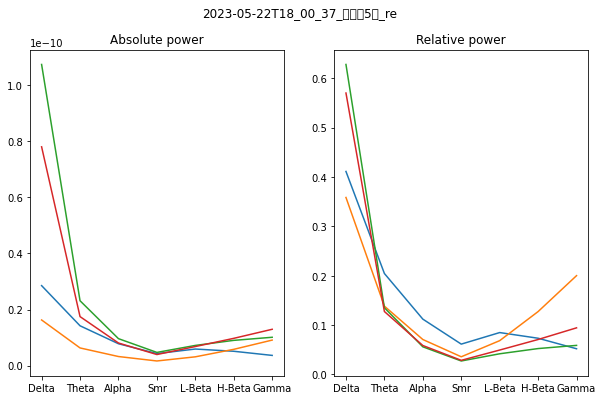

Overwriting existing file.
Overwriting existing file.


/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.388 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)


Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 75999  =      0.000 ...   303.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 53916 (\N{HANGUL SYLLABLE TYU}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]

Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 395 (average pulse 77 / min.)


/tmp/ipykernel_636/4083100305.py:62: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ecg_annot)


Creating RawArray with float64 data, n_channels=4, n_times=512523
    Range : 0 ... 512522 =      0.000 ...  2050.088 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

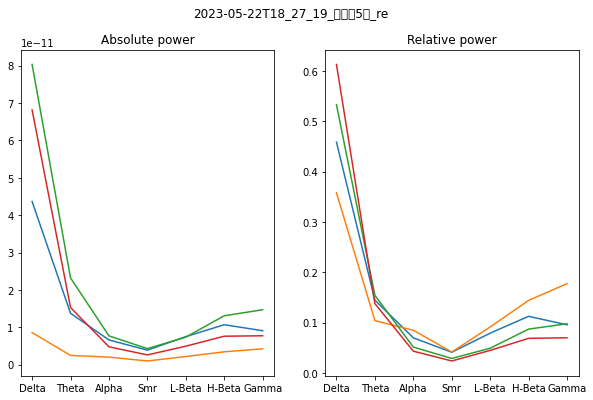

Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 79499  =      0.000 ...   317.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.908 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)
/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 53916 (\N{HANGUL SYLLABLE TYU}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/1901988796.py:24: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.savefig(title+'.png', dpi=100)
/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 446 (average pulse 84 / min.)
Creating RawArray with float64 data, n_channels=4, n_times=57318
    Range : 0 ... 57317 =      0.000 ...   229.268 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

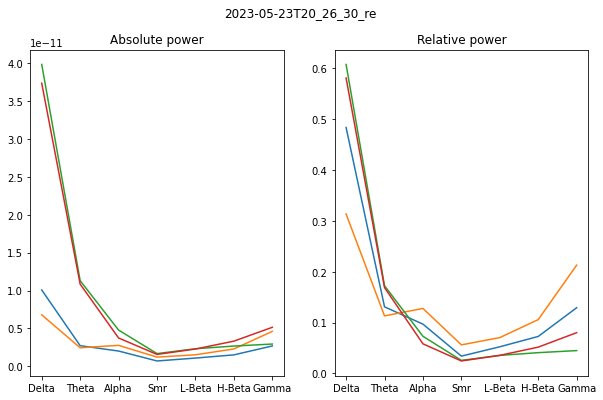

Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 78249  =      0.000 ...   312.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.728 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)
/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent

Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 461 (average pulse 88 / min.)
Creating RawArray with float64 data, n_channels=4, n_times=290188
    Range : 0 ... 290187 =      0.000 ...  1160.748 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

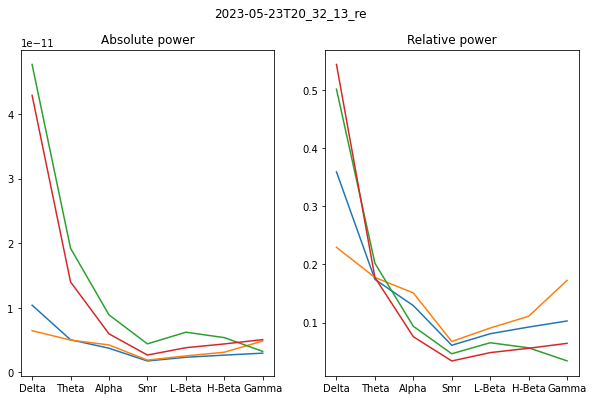

/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.248 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)


Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 78249  =      0.000 ...   312.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0

Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 385 (average pulse 73 / min.)
Creating RawArray with float64 data, n_channels=4, n_times=606853
    Range : 0 ... 606852 =      0.000 ...  2427.408 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


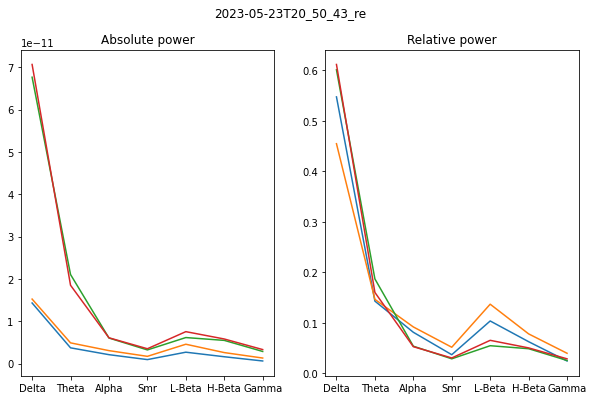

Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 77499  =      0.000 ...   309.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz



/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.588 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)
/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 352 (average pulse 68 / min.)
Creating RawArray with float64 data, n_channels=4, n_times=525187
    Range : 0 ... 525186 =      0.000 ...  2100.744 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

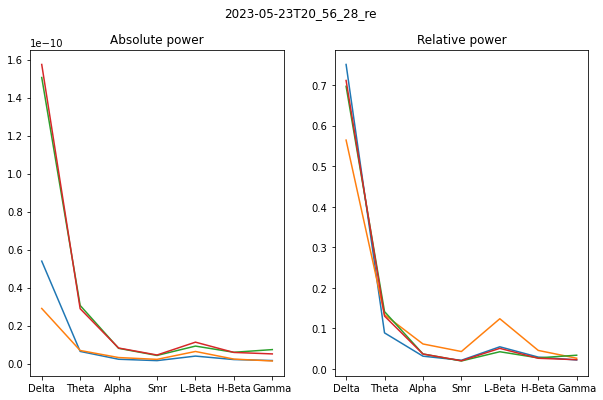

Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 79249  =      0.000 ...   316.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------


/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.252 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)
/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 435 (average pulse 82 / min.)
Creating RawArray with float64 data, n_channels=4, n_times=1008855
    Range : 0 ... 1008854 =      0.000 ...  4035.416 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


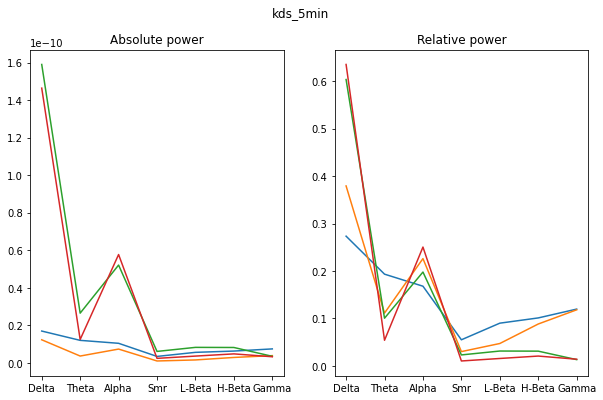

Sampling frequency of the instance is already 250.0, returning unmodified.
Reading 0 ... 80999  =      0.000 ...   323.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.58 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)
/tmp/ipykernel_636/4083100305.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG100C'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fname+'.edf', verbose=0)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Using channel EEG100C-1 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 369 (average pulse 68 / min.)
Creating RawArray with float64 data, n_channels=4, n_times=467823
    Range : 0 ... 467822 =      0.000 ...  1871.288 secs
Ready.
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

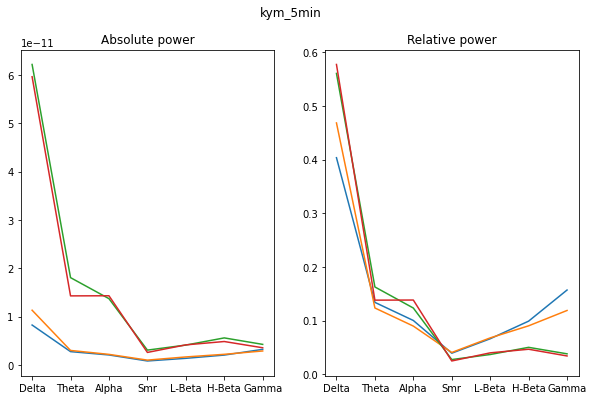

/tmp/ipykernel_636/2306613870.py:12: RuntimeWarning: EDF format requires equal-length data blocks, so 0.708 seconds of zeros were appended to all channels when writing the final block.
  data.export(fname=fname+'.edf', fmt='edf', overwrite=True)


In [16]:
# Store computed power (Datafram)
abs_power_set = []
rel_power_set = []
files = []

for each in list_files:
    
    files.append(each)
    # Preprocess
    tem_raw, raw_data_no_nan  = preprocessing_eeg(fname=each)
    
    # Get power with FFT transform
    power, rel_power = power_computation(data=raw_data_no_nan)
    
    abs_power_set.append(power)
    rel_power_set.append(rel_power)
    
    # PSD plot
    #psd_plot(data=tem_raw)
    
    # Power plot
    power_plot(power=power, rel_power=rel_power, title=each)
    
    # Save each data into edf and .set under new directory named as data name
    processed_file_saving(data=tem_raw, fname=each)
    
    # Save power plot
    power_plot_save(power=power, rel_power=rel_power, title=each)

# save dataframes into excel file, each datafram as a seperate TAB in Excel
power_saving(abs_power=abs_power_set, rel_power=rel_power_set, fnames=files)